## Importing necesarry libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import TimeSeriesSplit
sb.set()

1. **Hyperparameter Tuning for SARIMAX Model**

The forecasting accuracy of SARIMAX models heavily relies on the selection of hyperparameters. These hyperparameters define the structure of the autoregressive (AR), differencing (I), and moving average (MA) components of the model, including the seasonal counterparts.

In order to find the optimal set of hyperparameters, we implement a comprehensive grid search approach. The function sarimax_hyperparameter_tuning systematically explores combinations of hyperparameters within specified ranges. It assesses each model using the Akaike Information Criterion (AIC), a widely used statistical measure that trades off between the goodness of fit and the simplicity of the model.

*Function Overview:*

Inputs: The function takes the training dataset and lists of possible values for the hyperparameters of both the non-seasonal and seasonal components of the SARIMAX model.

Process: It iterates over all possible combinations of the provided hyperparameters, fitting a SARIMAX model to the training data for each combination.

Outputs: The function returns the model with the lowest AIC value, indicating the best balance between model complexity and fit, along with the corresponding set of hyperparameters.

This automated process aids in model selection by ensuring that we identify the most appropriate model specification without manually testing each possible combination. The selected hyperparameters are crucial for our subsequent forecasts, as they significantly affect the model's predictive performance.

In [2]:
def sarimax_hyperparameter_tuning(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    """
    Perform grid search hyperparameter tuning for SARIMAX model.
    
    """
    best_aic = float("inf")
    best_params = None
    best_model = None

    # Generate all combinations of hyperparameters
    params_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))
    
    warnings.filterwarnings("ignore")  # Ignore warning messages for model convergence issues

    # Grid search
    for params in params_combinations:
        try:
            model = SARIMAX(train_data,
                            order=(params[0], params[1], params[2]),
                            seasonal_order=(params[3], params[4], params[5], params[6]),
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            model_fit = model.fit(disp=0)

            # Compare this model's AIC with the best AIC found so far
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = params
                best_model = model_fit
        except Exception as e:
            continue  

    warnings.resetwarnings() 

    return best_model, best_params

In [3]:
energy_production = pd.read_csv('renewablePowerGeneration97-17 (1).csv')
energy_production['Total (TWh)'] = (energy_production['Hydro(TWh)']+
                                    energy_production['Biofuel(TWh)']+
                                        energy_production['Solar PV (TWh)']+energy_production['Geothermal (TWh)'])

# Converting 'Year' to a datetime object and set as index for creating timeseries 
energy_production['Year'] = pd.to_datetime(energy_production['Year'], format='%Y')
energy_production.set_index('Year', inplace=True)

In [4]:
energy_production.head()

,Hydro(TWh),Biofuel(TWh),Solar PV (TWh),Geothermal (TWh),Total (TWh)
Year,,,,,
1990-01-01,2191.67,3.88,0.09,36.42,2232.06
1991-01-01,2268.63,4.19,0.10,37.39,2310.31
1992-01-01,2267.16,4.63,0.12,39.30,2311.21
1993-01-01,2397.67,5.61,0.15,40.23,2443.66
1994-01-01,2419.73,7.31,0.17,41.05,2468.26


2. **Forecasting Future Energy Production with SARIMAX**

In this section, we introduce the sarimax_pred function, a key component of our energy forecasting toolkit. This function is designed to predict future production levels for various types of energy using Seasonal AutoRegressive Integrated Moving Average with eXogenous variables (SARIMAX) model, a sophisticated statistical method well-suited for time series data exhibiting seasonal patterns.

*Functionality Overview:*
    
Parameter Inputs: The function allows for flexible input of the energy type to forecast, the start year for predictions, the number of forecast steps, and the SARIMAX hyperparameters (p, d, q, P, D, Q, s).
    
Data Handling: Internally, the function processes a comprehensive dataset of historical renewable energy production, ranging from hydro to geothermal sources. The dataset is cleaned, prepared, and partitioned into training and test sets.
    
Model Fitting: Leveraging the SARIMAX model, we fit historical data to capture underlying patterns, trends, and seasonality.
    
Forecast Generation: The function then projects future energy production up to 15 years ahead, providing both point estimates and confidence intervals for the forecasts.
    
Visualization: Historical data and future forecasts are visualized to present a clear comparison and to convey the model's predictions effectively.
    
Diagnostics: Post-fitting diagnostics are included to assess the model's fit and to ensure that the underlying assumptions hold.
    
In-Sample Evaluation: After the model fitting, we perform in-sample predictions to evaluate how well the model can recreate the known data. This is crucial for understanding the model’s accuracy and identifying any potential overfitting or underfitting.


In [5]:
def sarimax_pred(energy_type, start_year='2017-01-01', forecast_steps=15,p=1,d=1,q=1,P=1,D=1,Q=1,s=12):
    
    energy_production = pd.read_csv('renewablePowerGeneration97-17 (1).csv')
    energy_production['Total (TWh)'] = energy_production['Hydro(TWh)']+energy_production['Biofuel(TWh)']+energy_production['Solar PV (TWh)']+energy_production['Geothermal (TWh)']

    # Converting 'Year' column to a datetime object and setting it as index to create time-series data
    energy_production['Year'] = pd.to_datetime(energy_production['Year'], format='%Y')
    energy_production.set_index('Year', inplace=True)

    # Selecting the column we're interested in based on the energy_type parameter
    target_data = energy_production[energy_type]

    # Split the data into training and testing sets
    train_end = pd.to_datetime(start_year)
    train_data = target_data[:train_end]
    last_hist_date = train_data.dropna().index[-1]
    test_data = target_data[train_end + pd.DateOffset(1):]

    # The SARIMAX order (p, d, q) and seasonal_order (P, D, Q, s) parameters should be determined 
    # through hyperparameter tuning
    sarima_model = SARIMAX(train_data, order=(p,d , q), seasonal_order=(P,D, Q, s))
    sarima_result = sarima_model.fit()

    # Forecasting for the next N steps beyond the dataset
    forecast = sarima_result.get_forecast(steps=forecast_steps)
    forecast_conf_int = forecast.conf_int()

    forecast_index = pd.date_range(start=last_hist_date, periods=forecast_steps, freq='AS')

    # Constructing a DataFrame to store the forecast
    forecast_df = pd.DataFrame({
        f'{energy_type}_forecast': forecast.predicted_mean,
        'Lower_Confidence_Interval': forecast_conf_int.iloc[:, 0],
        'Upper_Confidence_Interval': forecast_conf_int.iloc[:, 1]
    }, index=forecast_index)

    # Plotting historical and forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(target_data, label='Historical')
    plt.plot(forecast_df[f'{energy_type}_forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
                     forecast_df['Lower_Confidence_Interval'],
                     forecast_df['Upper_Confidence_Interval'], color='pink', alpha=0.5)
    plt.title(f'{energy_type} Energy Production Forecast')
    plt.xlabel('Year')
    plt.ylabel(f'{energy_type} (TWh)')
    plt.legend()
    plt.show()
    sarima_result = sarima_model.fit()

    # Plot Diagnostics
    sarima_result.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # In-sample prediction
    in_sample_prediction = sarima_result.get_prediction(start=train_data.index[0], end=last_hist_date)
    in_sample_prediction_conf_int = in_sample_prediction.conf_int()

    # Compare in-sample predictions to actual values
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Actual')
    plt.plot(in_sample_prediction.predicted_mean, label='In-sample Prediction', color='red')
    plt.fill_between(in_sample_prediction_conf_int.index,
                     in_sample_prediction_conf_int.iloc[:, 0],
                     in_sample_prediction_conf_int.iloc[:, 1], color='pink', alpha=0.5)
    plt.title('In-sample Prediction vs Actual')
    plt.legend()
    plt.show()
    predicted_values = in_sample_prediction.predicted_mean
    actual_values = train_data[in_sample_prediction.predicted_mean.index]


    return actual_values,predicted_values

**3. Hyperparameter tuning for the 'Hydro(TWh)' energy and then passing in the ideal p,d,q,P,D,Q,s values for forecasting.**


In [6]:
target_data = energy_production['Hydro(TWh)']


train_end = pd.to_datetime('2017-01-01')
train_data = target_data[:train_end]

#performing hyper parameter tuning

best_model, best_params = sarimax_hyperparameter_tuning(train_data,range(0, 3),[1,2]
                                                        ,range(0, 3),range(0, 3),[1],range(0, 3),[12])
print(f"Best Model's AIC: {best_model.aic}")
print(f"Best Parameters: {best_params}")

Best Model's AIC: -0.6055653764147833
Best Parameters: (0, 1, 1, 0, 1, 1, 12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98931D+00    |proj g|=  5.02115D-02


/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  3.97365D+00    |proj g|=  7.36923D-04

At iterate   10    f=  3.97341D+00    |proj g|=  5.31683D-03

At iterate   15    f=  3.93002D+00    |proj g|=  1.18358D-02

At iterate   20    f=  3.91113D+00    |proj g|=  2.85987D-03
  ys=-3.938E-04  -gs= 2.451E-03 BFGS update SKIPPED

At iterate   25    f=  3.90843D+00    |proj g|=  7.27259D-05

At iterate   30    f=  3.90840D+00    |proj g|=  2.37126D-04

At iterate   35    f=  3.90838D+00    |proj g|=  4.69146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     58      1     1     0   9.081D-06   3.908D+00
  F =   3.9083757260349148     

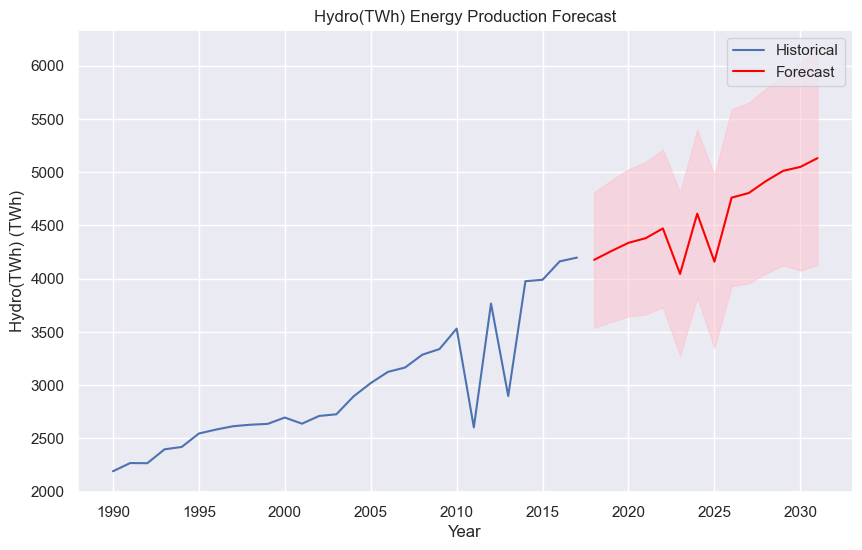

/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98931D+00    |proj g|=  5.02115D-02

At iterate    5    f=  3.97365D+00    |proj g|=  7.36923D-04

At iterate   10    f=  3.97341D+00    |proj g|=  5.31683D-03

At iterate   15    f=  3.93002D+00    |proj g|=  1.18358D-02

At iterate   20    f=  3.91113D+00    |proj g|=  2.85987D-03
  ys=-3.938E-04  -gs= 2.451E-03 BFGS update SKIPPED

At iterate   25    f=  3.90843D+00    |proj g|=  7.27259D-05

At iterate   30    f=  3.90840D+00    |proj g|=  2.37126D-04

At iterate   35    f=  3.90838D+00    |proj g|=  4.69146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

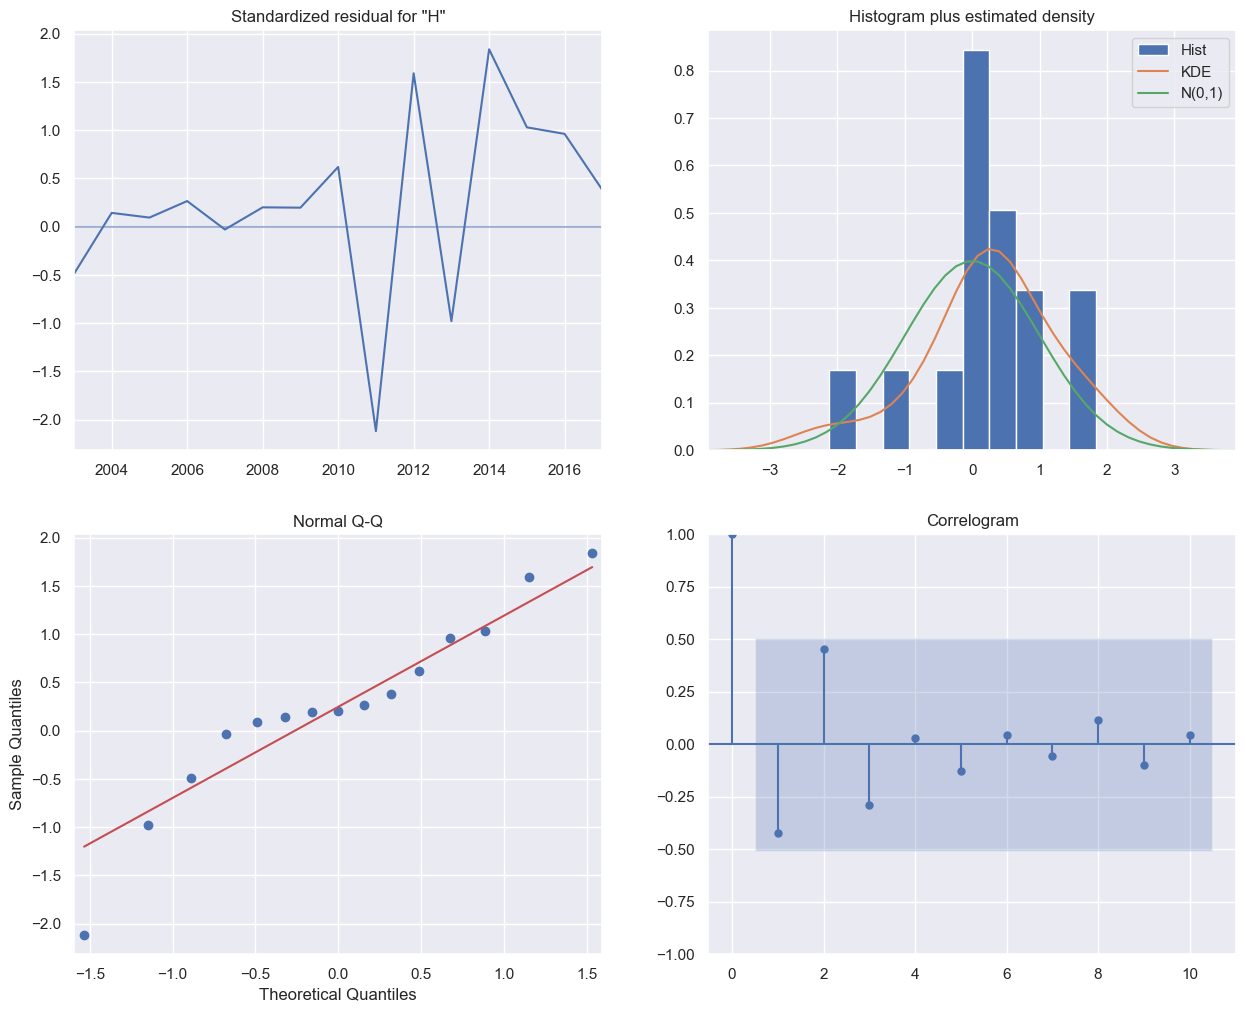

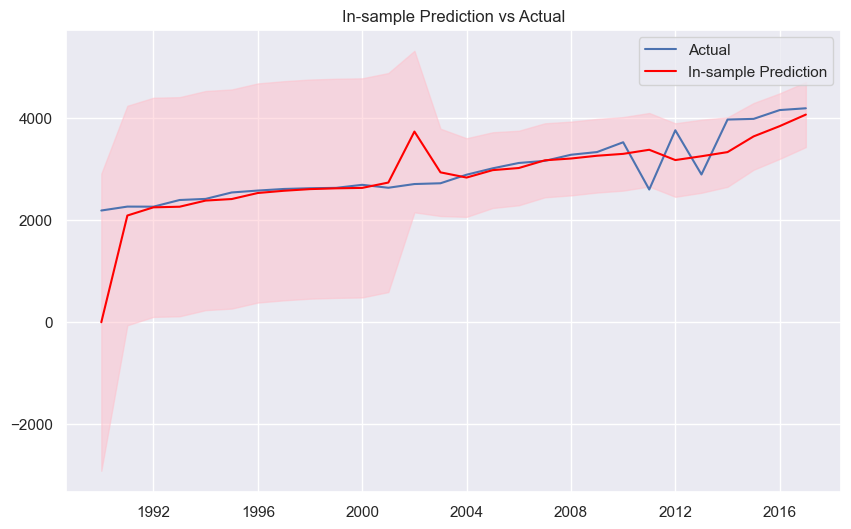

In [7]:
actual_hydro,predicted_hydro = sarimax_pred('Hydro(TWh)',p=0,d=1,q=1,P=0,D=1,Q=1,s=12)

**4. Hyperparameter tuning for the 'Solar PV (TWh)' energy and then passing in the ideal p,d,q,P,D,Q,s values for forecasting.**


In [8]:
target_data = energy_production['Solar PV (TWh)']


train_end = pd.to_datetime('2017-01-01')
train_data = target_data[:train_end]

best_model, best_params = sarimax_hyperparameter_tuning(train_data,range(0, 3),[1,2],range(0, 3),range(0, 3),[1],range(0, 3),[12])
print(f"Best Model's AIC: {best_model.aic}")
print(f"Best Parameters: {best_params}")

Best Model's AIC: -6.869610585486354
Best Parameters: (1, 2, 0, 1, 1, 1, 12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10976D+00    |proj g|=  6.26780D-01


/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.78810D+00    |proj g|=  5.03385D-03

At iterate   10    f=  1.78748D+00    |proj g|=  2.59959D-05

At iterate   15    f=  1.78747D+00    |proj g|=  9.86960D-04

At iterate   20    f=  1.78744D+00    |proj g|=  2.38635D-04

At iterate   25    f=  1.78742D+00    |proj g|=  1.07993D-04

At iterate   30    f=  1.78742D+00    |proj g|=  1.12286D-04

At iterate   35    f=  1.78741D+00    |proj g|=  4.63761D-05

At iterate   40    f=  1.78741D+00    |proj g|=  3.38320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     54      1     0     0   3.393D-05   1.787D+00
  F =   1.78741323061

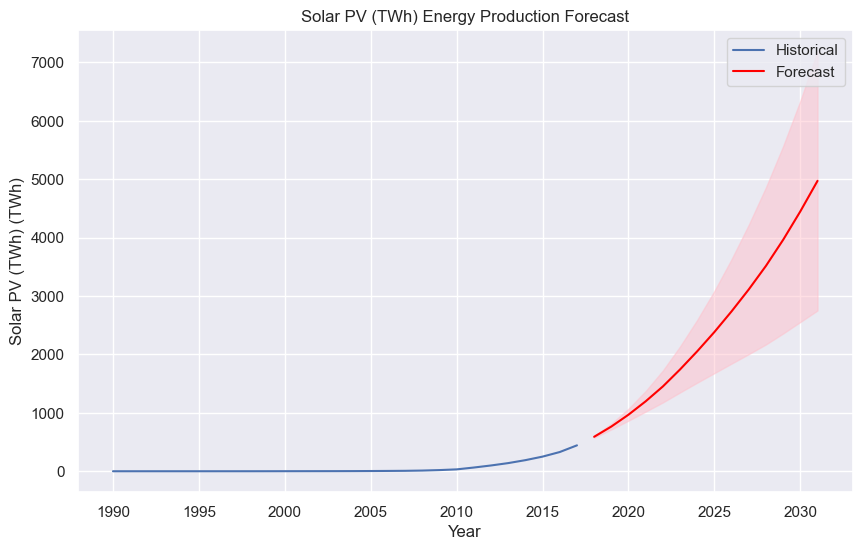

/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10976D+00    |proj g|=  6.26780D-01

At iterate    5    f=  1.78810D+00    |proj g|=  5.03385D-03

At iterate   10    f=  1.78748D+00    |proj g|=  2.59959D-05

At iterate   15    f=  1.78747D+00    |proj g|=  9.86960D-04

At iterate   20    f=  1.78744D+00    |proj g|=  2.38635D-04

At iterate   25    f=  1.78742D+00    |proj g|=  1.07993D-04

At iterate   30    f=  1.78742D+00    |proj g|=  1.12286D-04

At iterate   35    f=  1.78741D+00    |proj g|=  4.63761D-05

At iterate   40    f=  1.78741D+00    |proj g|=  3.38320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

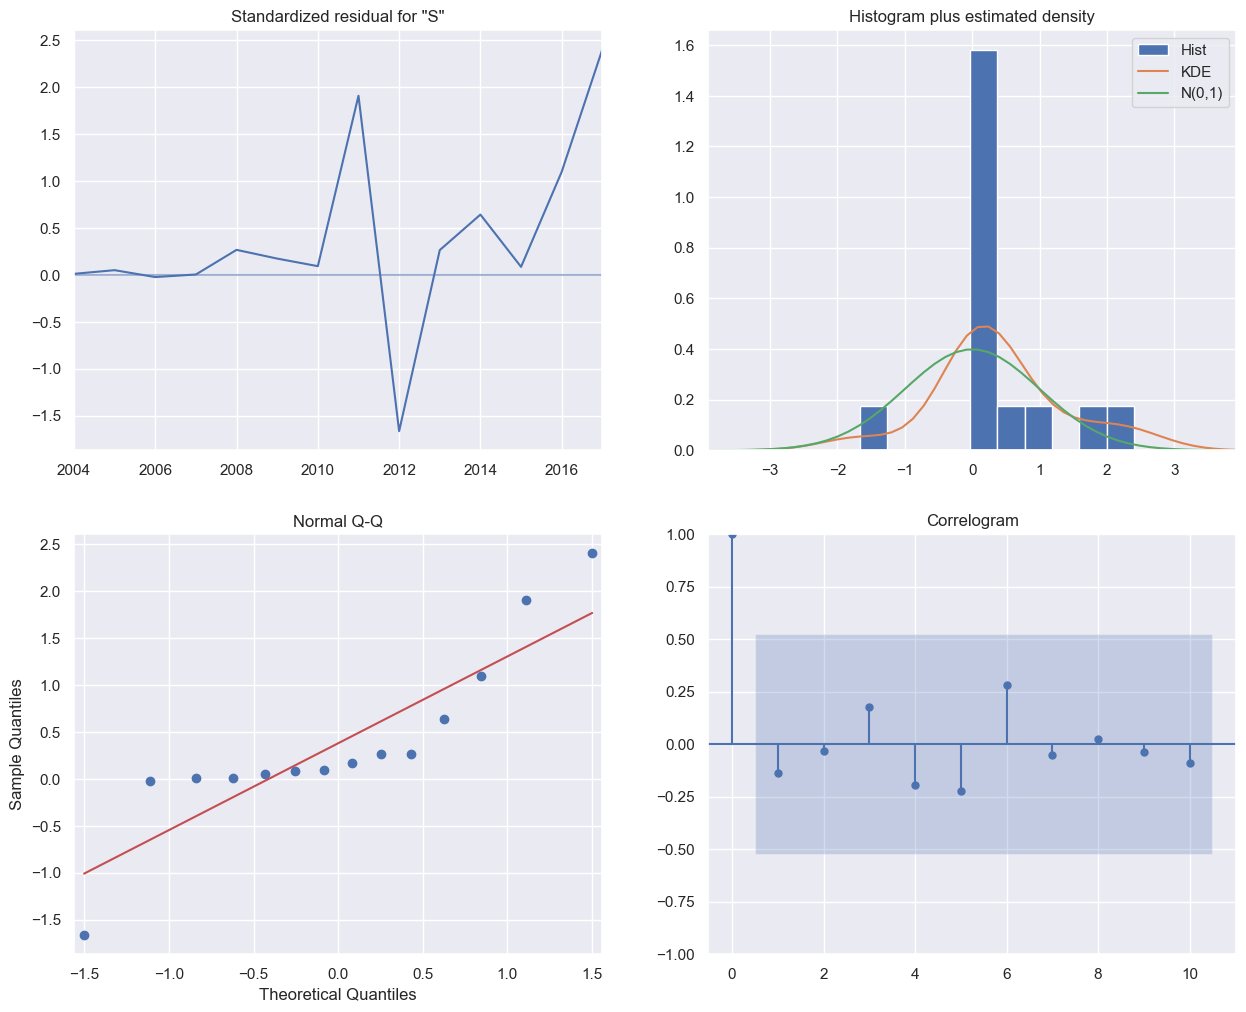

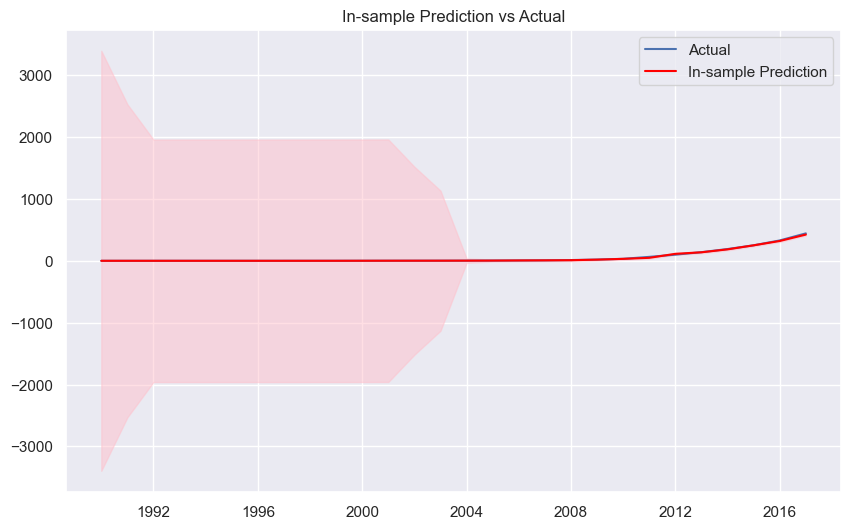

In [9]:
actual_solar,predicted_solar = sarimax_pred('Solar PV (TWh)',p=1,d=2,q=0,P=1,D=1,Q=1,s=12)

**5. Hyperparameter tuning for the 'Biofuel(TWh)' energy and then passing in the ideal p,d,q,P,D,Q,s values for forecasting.**


In [10]:
target_data = energy_production['Biofuel(TWh)']


train_end = pd.to_datetime('2017-01-01')
train_data = target_data[:train_end]

best_model, best_params = sarimax_hyperparameter_tuning(train_data,range(0, 3),[1,2],range(0, 3),range(0, 3),[1],range(0, 3),[12])
print(f"Best Model's AIC: {best_model.aic}")
print(f"Best Parameters: {best_params}")

Best Model's AIC: -12.075367312533473
Best Parameters: (1, 1, 0, 1, 1, 0, 12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30593D+00    |proj g|=  3.28310D+00

At iterate    5    f=  2.60197D+00    |proj g|=  3.31653D-02


/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  2.58515D+00    |proj g|=  1.02031D-03

At iterate   15    f=  2.58484D+00    |proj g|=  1.35193D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   2.775D-06   2.585D+00
  F =   2.5848427576596942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


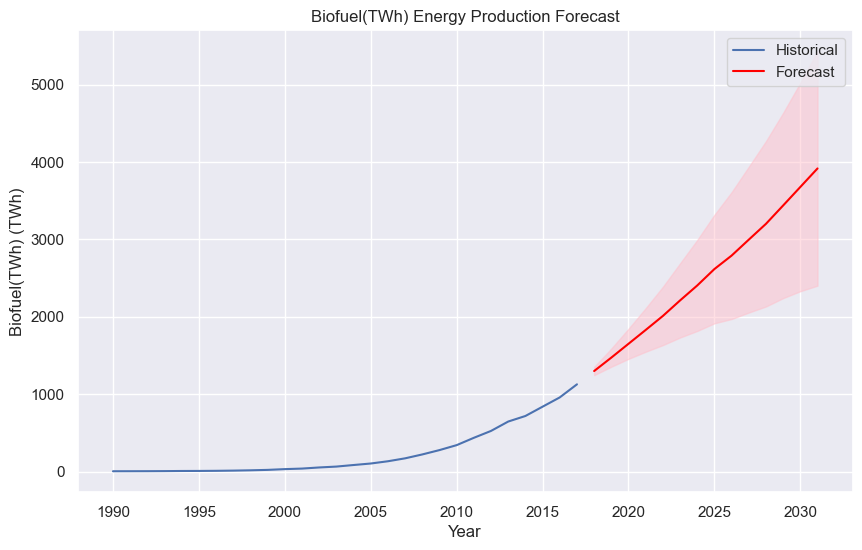

/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30593D+00    |proj g|=  3.28310D+00

At iterate    5    f=  2.60197D+00    |proj g|=  3.31653D-02

At iterate   10    f=  2.58515D+00    |proj g|=  1.02031D-03

At iterate   15    f=  2.58484D+00    |proj g|=  1.35193D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   2.775D-06   2.585D+00
  F =   2.5848427576596942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


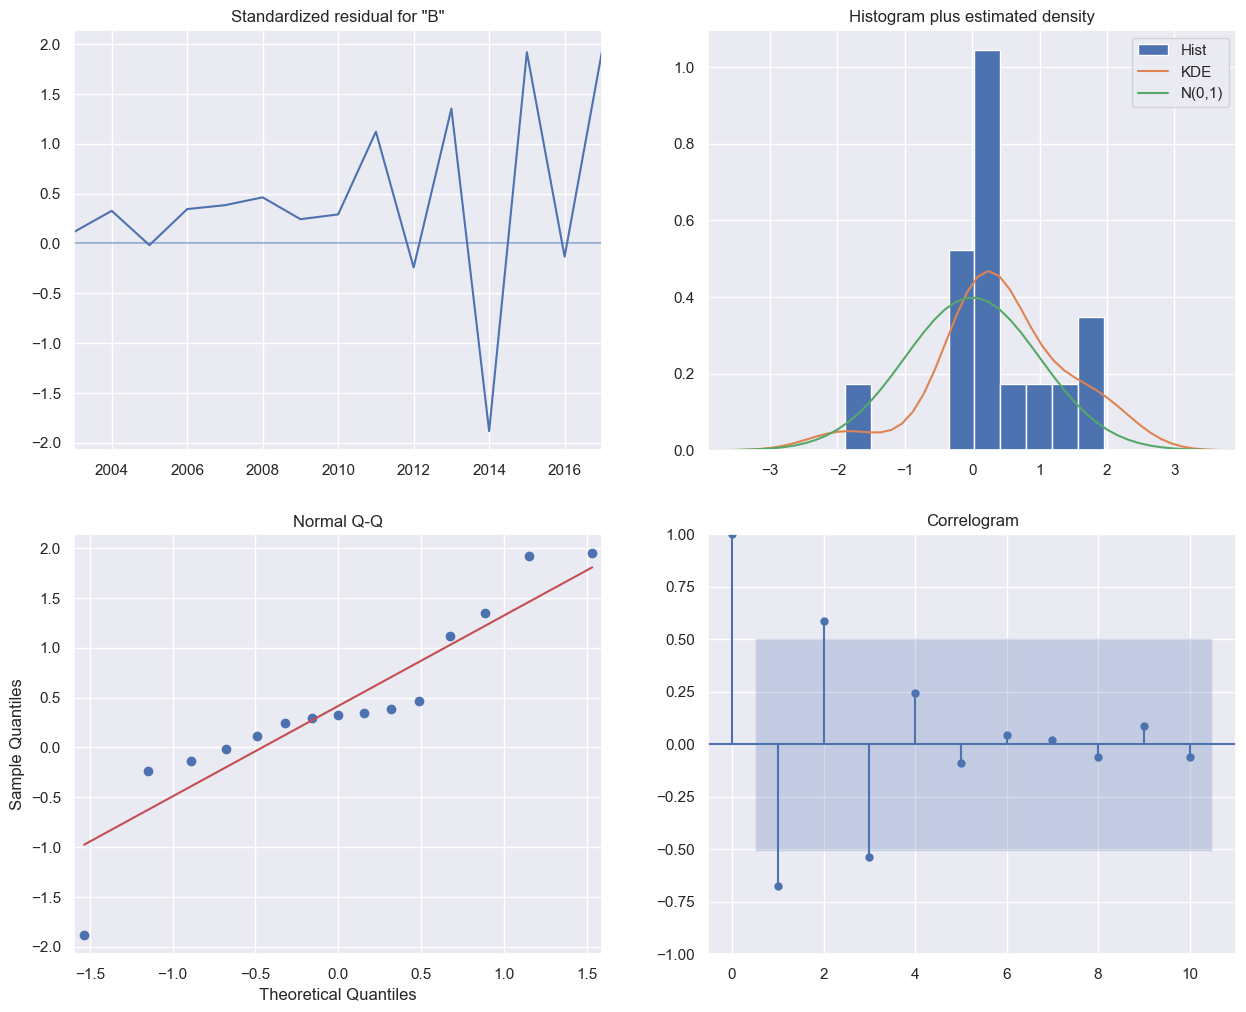

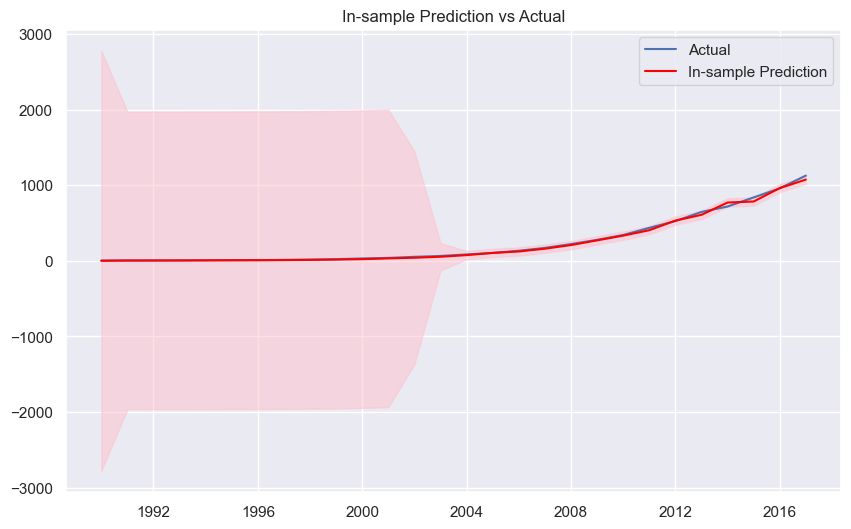

In [11]:
actual_biofuel,predicted_biofuel = sarimax_pred('Biofuel(TWh)',p=1,d=1,q=0,P=1,D=1,Q=0,s=12)

**6. Hyperparameter tuning for the 'Geothermal (TWh)' energy and then passing in the ideal p,d,q,P,D,Q,s values for forecasting.**

In [12]:
target_data = energy_production['Geothermal (TWh)']


train_end = pd.to_datetime('2017-01-01')
train_data = target_data[:train_end]

best_model, best_params = sarimax_hyperparameter_tuning(train_data,range(0, 3),[1,2],range(0, 3),range(0, 3),[1],range(0, 3),[12])
print(f"Best Model's AIC: {best_model.aic}")
print(f"Best Parameters: {best_params}")

Best Model's AIC: -32.860619644255806
Best Parameters: (1, 1, 0, 1, 1, 1, 12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13890D+00    |proj g|=  1.46885D-02


/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.09419D+00    |proj g|=  1.04469D-01

At iterate   10    f=  1.09041D+00    |proj g|=  7.78494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   5.017D-06   1.090D+00
  F =   1.0904043513343280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


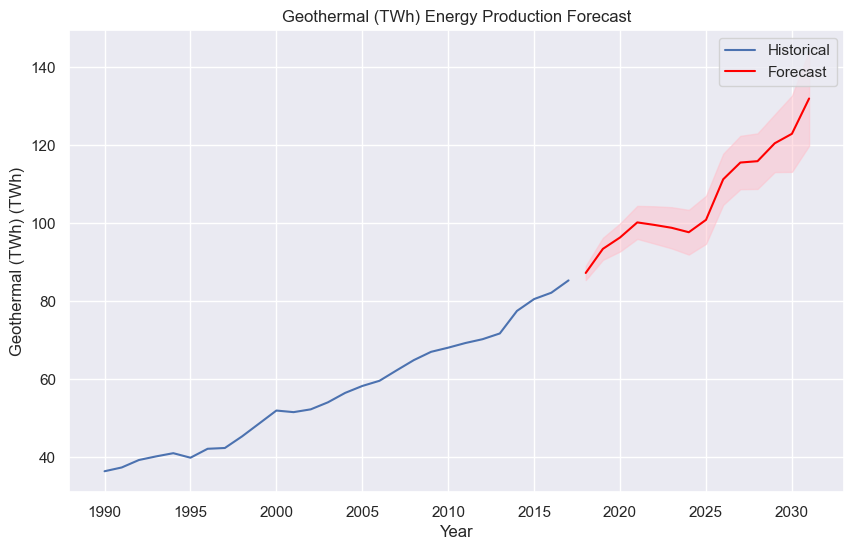

/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13890D+00    |proj g|=  1.46885D-02

At iterate    5    f=  1.09419D+00    |proj g|=  1.04469D-01

At iterate   10    f=  1.09041D+00    |proj g|=  7.78494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   5.017D-06   1.090D+00
  F =   1.0904043513343280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


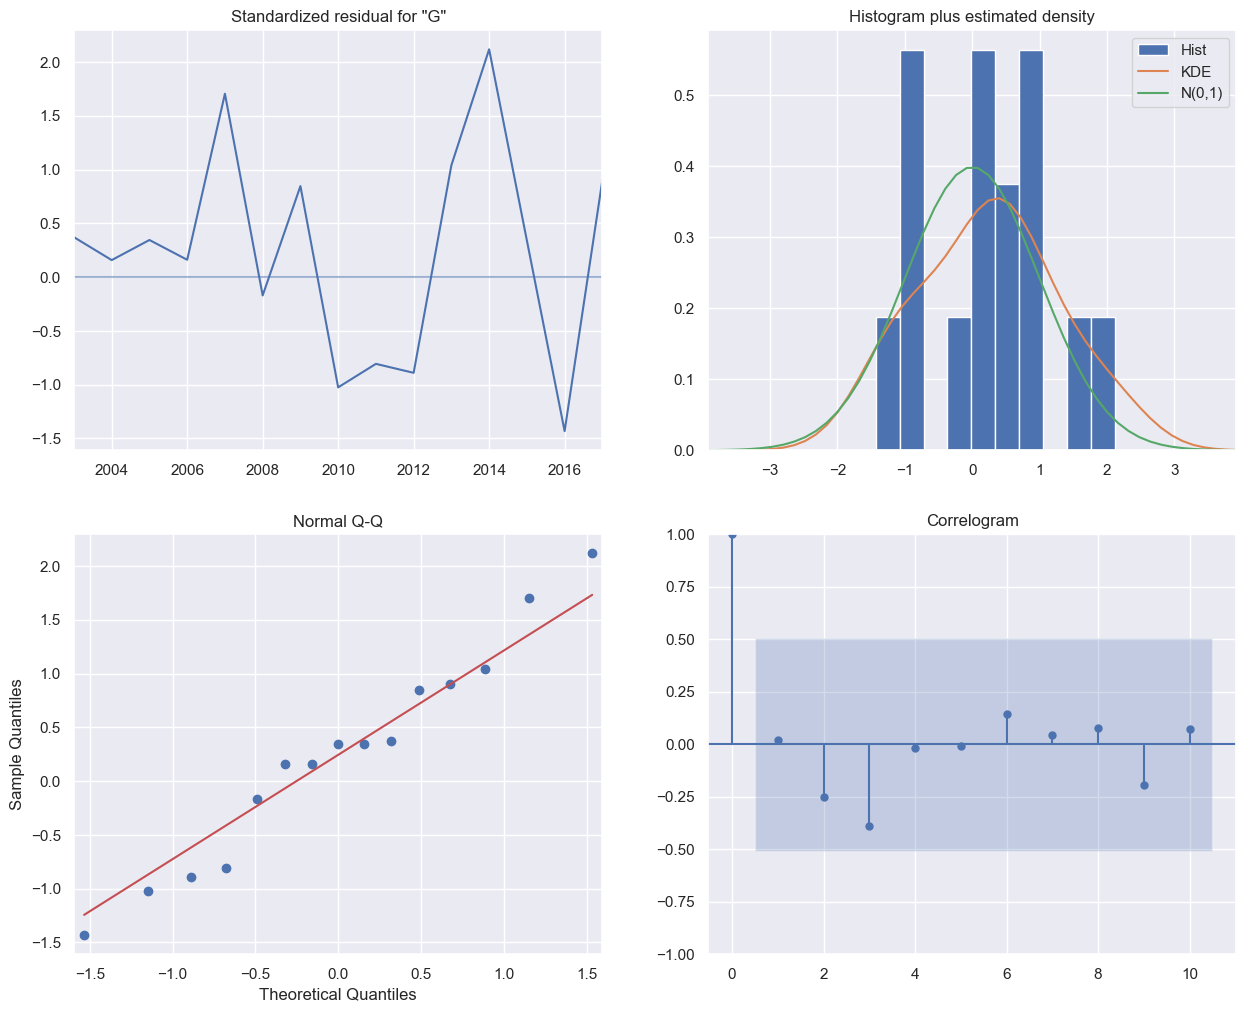

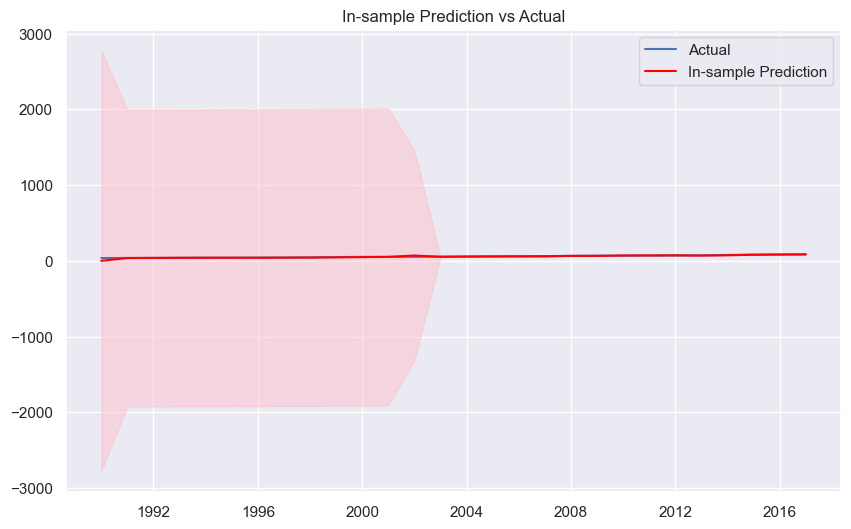

In [13]:
actual_geothermal,predicted_geothermal = sarimax_pred('Geothermal (TWh)',p=1,d=1,q=0,P=1,D=1,Q=1,s=12)

**7. Hyperparameter tuning for the 'Total (TWh)' energy and then passing in the ideal p,d,q,P,D,Q,s values for forecasting.**

In [14]:
target_data = energy_production['Total (TWh)']


train_end = pd.to_datetime('2017-01-01')
train_data = target_data[:train_end]

best_model, best_params = sarimax_hyperparameter_tuning(train_data,range(0, 3),[1,2],range(0, 3),range(0, 3),[1],range(0, 3),[12])
print(f"Best Model's AIC: {best_model.aic}")
print(f"Best Parameters: {best_params}")

Best Model's AIC: -14.975150485548383
Best Parameters: (1, 1, 0, 1, 1, 0, 12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06971D+00    |proj g|=  8.84866D-02


/Users/aryanjain/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.97954D+00    |proj g|=  2.86093D-04

At iterate   10    f=  3.97939D+00    |proj g|=  4.37064D-03

At iterate   15    f=  3.96966D+00    |proj g|=  3.07942D-02

At iterate   20    f=  3.96018D+00    |proj g|=  3.83323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   1.003D-06   3.960D+00
  F =   3.9601803608099444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


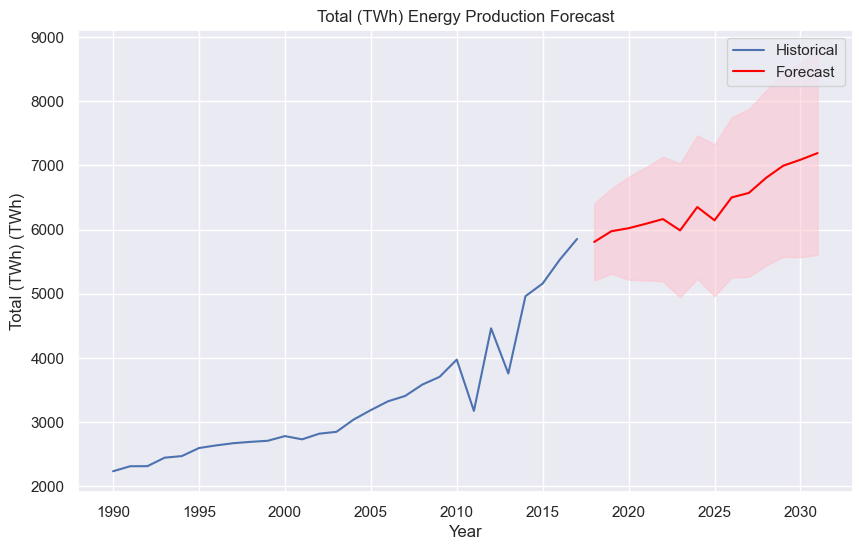

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06971D+00    |proj g|=  8.84866D-02

At iterate    5    f=  3.97954D+00    |proj g|=  2.86093D-04

At iterate   10    f=  3.97939D+00    |proj g|=  4.37064D-03

At iterate   15    f=  3.96966D+00    |proj g|=  3.07942D-02

At iterate   20    f=  3.96018D+00    |proj g|=  3.83323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   1.003D-06   3.960D+00
  F =   3.9601803608099444     

CONVERG

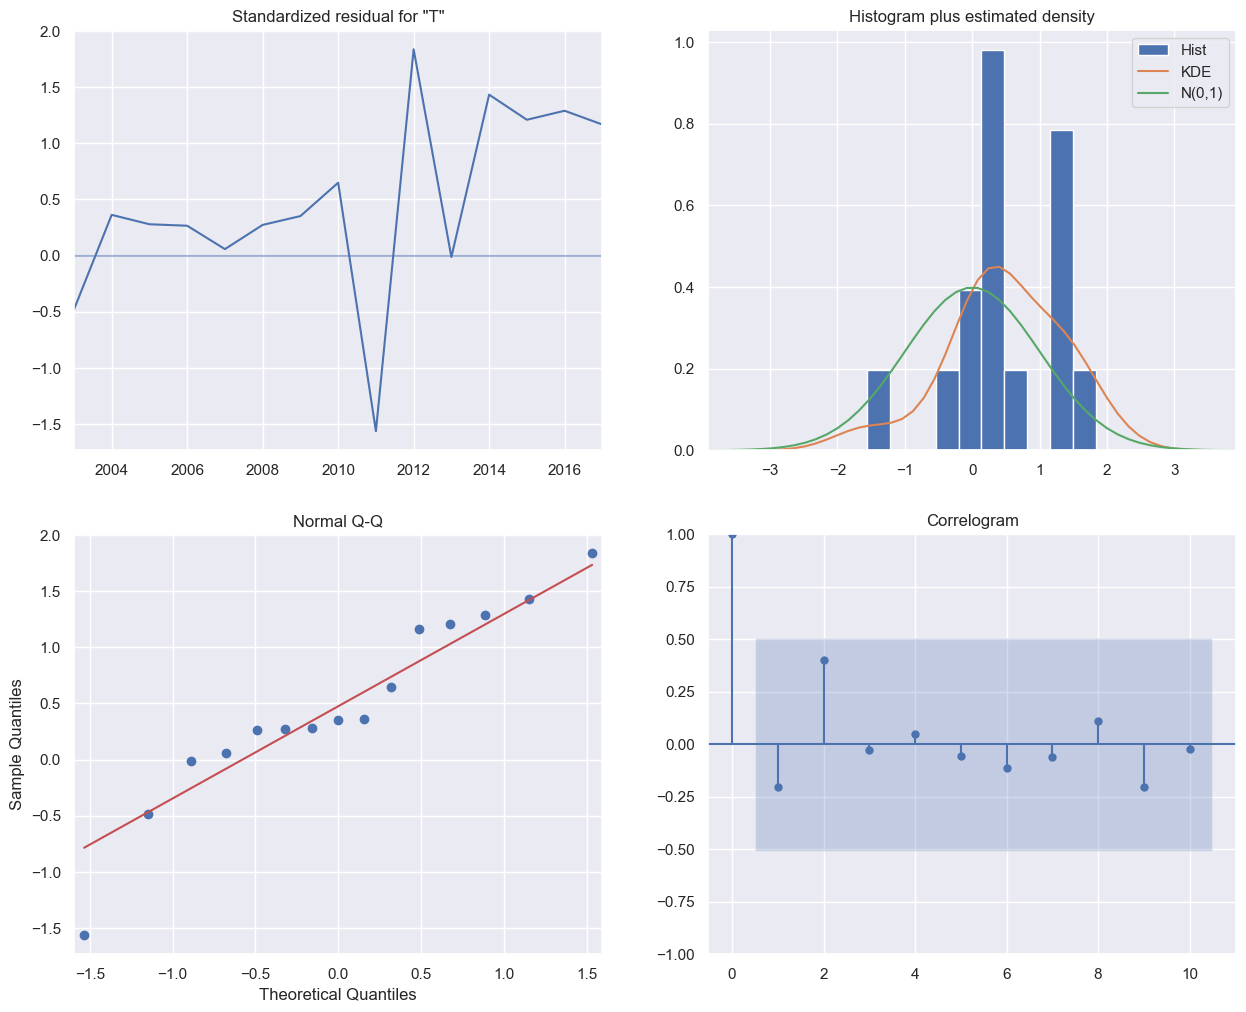

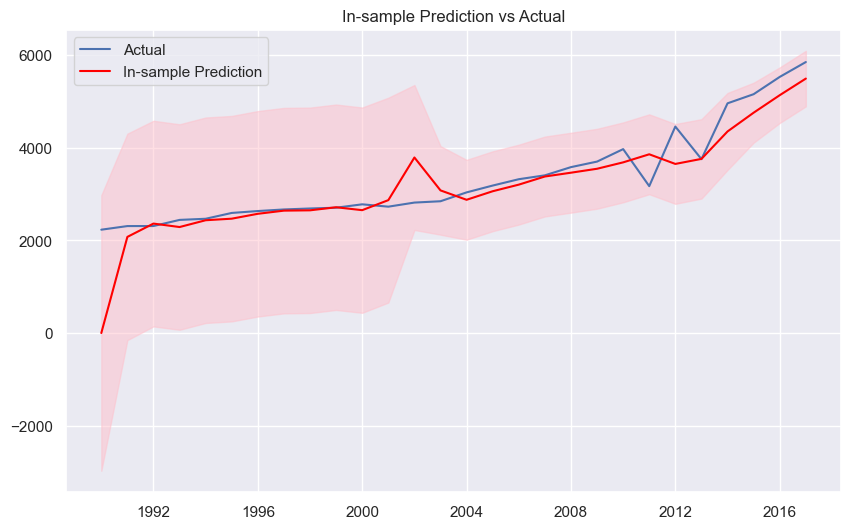

In [15]:
actual_total,predicted_total = sarimax_pred('Total (TWh)',p=1,d=1,q=0,P=1,D=1,Q=0,s=12)

## Comprehensive Insights from SARIMAX Model Diagnostics and Forecasting

Upon evaluating the SARIMAX model's performance through diagnostic plots and forecasting analysis, we can derive several insightful conclusions.

### Diagnostic Plots Analysis
The diagnostic plots for the model reveal the following:

- **Standardized Residuals**: The residuals do not show any apparent pattern, indicating a well-fitting model without systematic bias. However, some spikes suggest the presence of outliers or sudden shifts in the energy production not captured by the model.
  
- **Histogram and KDE**: The distribution of the residuals slightly deviates from the normal distribution, suggesting the presence of skewness. This could impact the model’s performance, potentially underestimating the probability of extreme events in energy production.

- **Q-Q Plot**: Some points deviate from the theoretical line, especially in the tails, indicating that extreme values are not as well-modeled as they could be. This might imply that transformations or robust methods could improve the model's handling of outliers.

- **ACF Plot**: Most autocorrelations seem to be within the confidence interval, suggesting that the model adequately captures the time series' autocorrelation. However, a careful examination of any significant lags could lead to further model refinement.

### Forecast Evaluation
The forecast plot indicates the model's capability to project future energy production, vital for planning and meeting sustainability targets.

- **Historical vs. Forecast**: The model captures the historical trend and seasonality and extends this pattern into the future. The forecast, represented by the red line, seems reasonable based on the historical data. However, the forecast confidence intervals widen over time, reflecting increasing uncertainty in long-term predictions.

- **Confidence Intervals**: The shaded area representing the confidence intervals is relatively wide, especially in later years, underscoring the need for caution in interpreting long-term forecasts. Decision-makers should account for this uncertainty in strategic planning.

- **In-sample Prediction**: The in-sample predictions align closely with the actual values, demonstrating the model's good fit to historical data. It is a positive indication that the model can replicate known patterns in the training dataset.

### Model Fitting and Problem Statement Implications
The model fitting indicates that the SARIMAX model can predict future energy production with a fair degree of accuracy, although improvements could be made, especially in dealing with potential outliers and extreme values. For the problem statement—forecasting future renewable energy production—the model provides a useful tool for anticipating trends and guiding energy policy and infrastructure investment decisions.

However, the model’s current limitations must be acknowledged, particularly in its ability to project further into the future where economic, technological, and policy factors may significantly alter energy production trends. The widening confidence intervals in the long-term forecast highlight the inherent uncertainty in such long-range predictions and underscore the importance of regularly updating models with new data.

In conclusion, the SARIMAX model has shown promise in forecasting renewable energy production, a critical component in the global push towards sustainable energy. Yet, ongoing model assessment, refinement, and incorporation of additional relevant predictors are essential to enhancing forecast reliability and utility for future energy planning and policy formulation.

**Growth Potential (Future prediction of Energies insight) : Solar and Biofuel energy sources demonstrate the most promising growth potential compared to Hydro and Geothermal energy. Hydro vs. Geothermal: While both Hydro and Geothermal energy show low CAGR values, Geothermal's growth potential is notably inferior to Hydro. This suggests that Geothermal energy has the lowest growth potential and energy generation capacity among the four sources, while Hydro remains a prominent but slower-growing renewable energy source.**


In [16]:
def calculate_performance_metrics(actual, predicted):
    """
    Calculating performance metrics for time series forecast.
    
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual, predicted)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual, predicted)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Symmetric Mean Absolute Percentage Error (sMAPE)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
    
    r_2 = r2_score(actual,predicted)
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'sMAPE': smape,
        'R^2': r_2
    }


## Error Metrics for Hydro Energy prediction (Goodness of Fit): 

In [17]:
calculate_performance_metrics(actual_hydro[1:],predicted_hydro[1:])

{'MAE': 211.64472406646476,
 'MSE': 110492.73500401933,
 'RMSE': 332.4044750060073,
 'MAPE': 6.918504448537385,
 'sMAPE': 6.673898143253733,
 'R^2': 0.6668121093442649}

## Error Metrics for Solar Energy prediction (Goodness of Fit): 

In [18]:
calculate_performance_metrics(actual_solar[1:],predicted_solar[1:])

{'MAE': 2.657440752018898,
 'MSE': 34.48686260767877,
 'RMSE': 5.872551626650784,
 'MAPE': 9.290325445653911,
 'sMAPE': 9.39800433089963,
 'R^2': 0.997288872183965}

## Error Metrics for Geothermal Energy prediction (Goodness of Fit): 

In [19]:
calculate_performance_metrics(actual_geothermal[1:],predicted_geothermal[1:])

{'MAE': 2.1999388200228625,
 'MSE': 15.17358859676439,
 'RMSE': 3.8953290742586035,
 'MAPE': 4.026752970482993,
 'sMAPE': 3.8985304498984084,
 'R^2': 0.9257102999129405}

## Error Metrics for BioFuel Energy prediction (Goodness of Fit): 

In [20]:
calculate_performance_metrics(actual_biofuel[1:],predicted_biofuel[1:])

{'MAE': 13.097288925699651,
 'MSE': 444.0003378225439,
 'RMSE': 21.07131552187817,
 'MAPE': 11.35056512893558,
 'sMAPE': 12.459687444324317,
 'R^2': 0.9958187587463638}

## Error Metrics for Total Energy prediction (Goodness of Fit): 

In [21]:
calculate_performance_metrics(actual_total[1:],predicted_total[1:])

{'MAE': 239.0316539667658,
 'MSE': 120590.4316227015,
 'RMSE': 347.26133044538875,
 'MAPE': 6.801630993846223,
 'sMAPE': 6.705088501752685,
 'R^2': 0.876694094260887}

### We are mostly concerned about the Total Renewable Energy column.

We can see that the **MAPE (Mean Absolute Percentage Error)** which expresses accuracy as a percentage of the error is quite low at **6.80%**. 

Also, the **R Square value** of **0.87** suggests that the model is a good fit on our data.

## Checking Stationarity of a Time Series

Stationarity in a time series means that its statistical properties, such as mean, variance, and covariance, remain constant over time. It is a crucial assumption in time series analysis, as many models require the data to be stationary.

### Plotting Rolling Statistics
- Rolling statistics are visual methods to assess stationarity. A moving average or moving variance is plotted to see if it varies with time, indicating non-stationarity.

### Dickey-Fuller Test
- The Dickey-Fuller test is a formal statistical test for stationarity. The null hypothesis assumes that the time series is non-stationary. A p-value less than a certain threshold (commonly 0.05) suggests rejecting the null hypothesis, indicating stationarity.

### KPSS Test
- The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test is another statistical test for stationarity. In contrast to the Dickey-Fuller test, the null hypothesis for the KPSS test assumes that the time series is stationary. A significant p-value indicates non-stationarity.

Proper application of these methods allows for the correct identification of stationarity, guiding the subsequent steps in the time series analysis.


In [22]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=6).mean()
    rolstd = timeseries.rolling(window=6).std()

    #Plot rolling statistics:
    f = plt.figure(figsize = (14,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print()
    
    #Perform KPSS test
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
    return

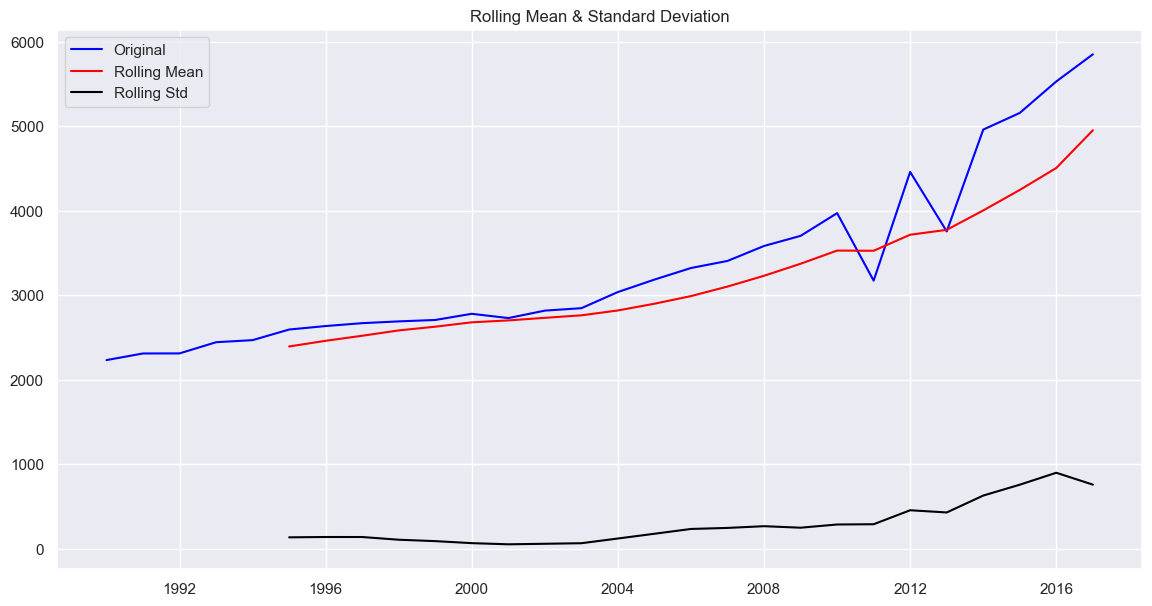

Results of Dickey-Fuller Test:
Test Statistic                  3.510832
p-value                         1.000000
#Lags Used                      7.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64

Results of KPSS Test:
Test Statistic           0.736494
p-value                  0.010228
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [23]:
# Testing stationarity of the Total Column 

# Will only focus on the Total henceforth

target_data = energy_production['Total (TWh)']
test_stationarity(target_data)

Since the Test Statistic of Dickey-Fuller Test is bigger than all the critical values we cannot say that the time series is stationary.

Hence, we have to make the time series stationary before fitting ARIMA.

## Making the Time Series Stationary

To reliably make predictions on a time series, the series should be stationary. This means that the statistical properties of the series like mean, variance, and covariance should not be a function of time. The following steps can be employed to achieve stationarity:

1. **By eliminating trends**:

   - Trends can be removed from a time series by applying transformations such as logarithms, differencing, etc.

2. **By eliminating noise**:

   - Smoothing techniques like rolling averages can help in reducing the noise and making the series smoother.

3. **By eliminating seasonality**:

   - Techniques such as differencing or decomposition can be used to remove seasonality from a time series.
   
Each of these steps can help in stabilizing the mean of the time series by removing changes in the level of a time series, and therefore stabilizing the variance.


In [24]:
def stationarizing(timeseries):
    
    #estimating and eliminating trend
    ts_log = np.log(timeseries)
    np.seterr(divide = 'ignore')
    ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log= ts_log.replace(np.nan,0)
    
    #smoothening to eliminate noise
    moving_avg = ts_log.rolling(6).mean()

    #eliminating trend and noise
    ts_log_moving_avg_diff = ts_log - moving_avg
    ts_log_moving_avg_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff= ts_log_moving_avg_diff.replace(np.nan,0)
    
    #using differencing to remove seasonality and trend
    ts_log_moving_avg_diff_diff=ts_log_moving_avg_diff-ts_log_moving_avg_diff.shift()
    ts_log_moving_avg_diff_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    
    #plotting graph after eliminating trend and seasonality
    f = plt.figure(figsize = (12,7))
    plt.title('Stationarized Series')
    plt.plot(ts_log_moving_avg_diff_diff)
    warnings.filterwarnings('ignore')
    
    return ts_log, moving_avg, ts_log_moving_avg_diff, ts_log_moving_avg_diff_diff

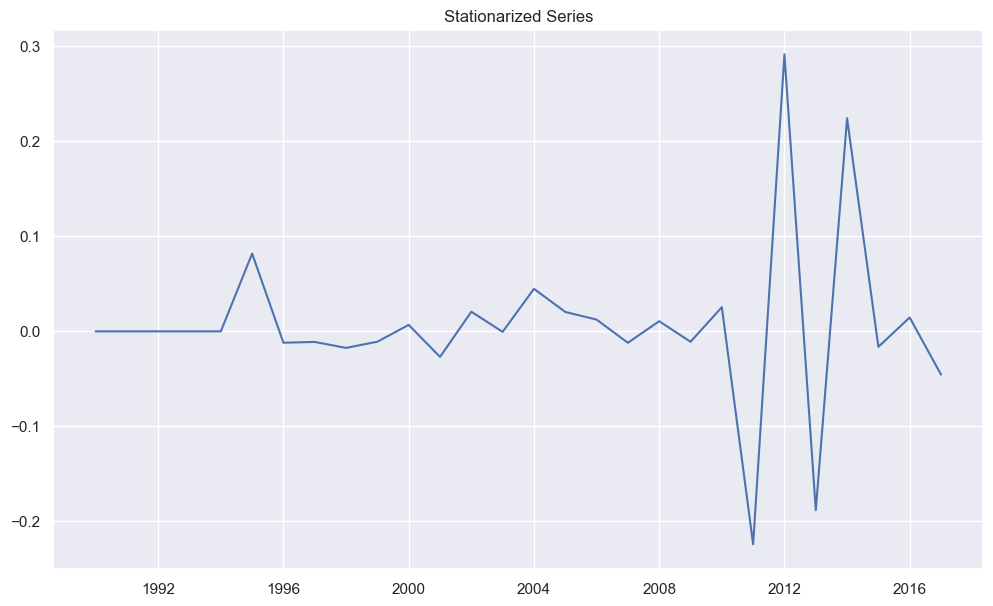

In [25]:
log_data, moving_avg_series, log_diff_data,stationarized_series = stationarizing(target_data)

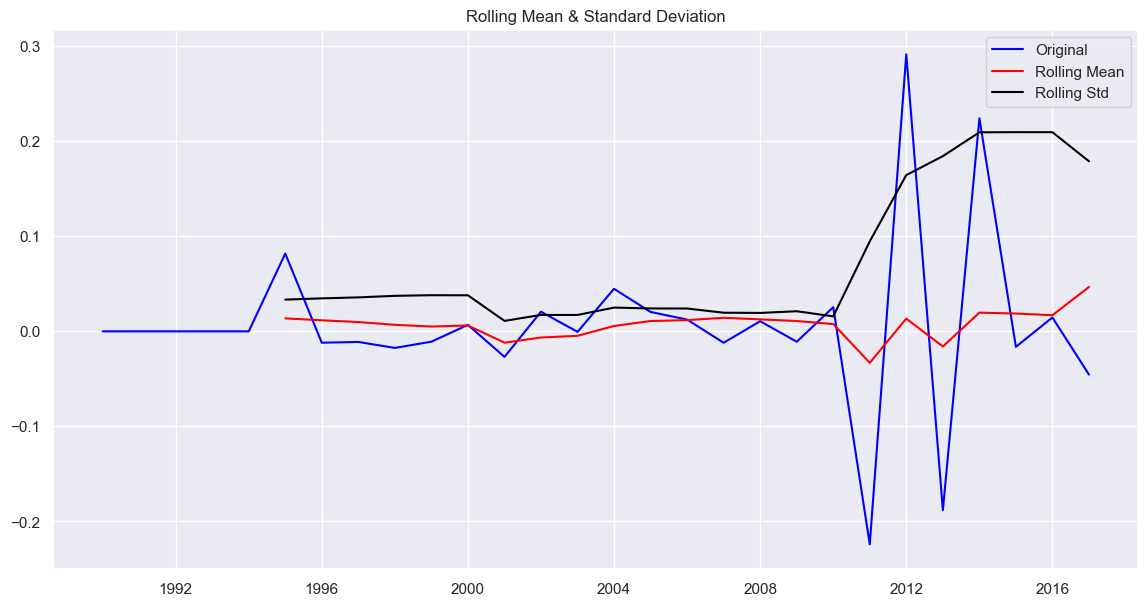

Results of Dickey-Fuller Test:
Test Statistic                 -3.043447
p-value                         0.031031
#Lags Used                      8.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64

Results of KPSS Test:
Test Statistic           0.072221
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [26]:
test_stationarity(stationarized_series)

## Stationarity Achieved

After applying the necessary transformations and tests, we have achieved stationarity in our time series data:

- The Test Statistic of the Dickey-Fuller test is **smaller than the critical values at all common significance levels** (1%, 5%, and 10%).
- This implies that we can **reject the null hypothesis with 99% confidence**, which posits that the series has a unit root and is non-stationary.
- We now have a **stationary series** that is suitable for modeling with ARIMA or other statistical methods that assume stationarity.

With stationarity established, we can proceed with fitting an ARIMA model to the data for forecasting or further analysis.


## Determining ARIMA Model Parameters (p, q)

To identify the appropriate order of the autoregressive (AR) and moving average (MA) components for our ARIMA model, we utilize the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF):

- The **ACF** helps us determine the optimal number of MA terms (q), by identifying the lag after which the autocorrelations are not significant.
- The **PACF** is used to identify the number of AR terms (p), by pinpointing the lag where the partial autocorrelations cut off or drop to zero beyond a certain point.

In [27]:
from statsmodels.tsa.stattools import acf, pacf
def findParameters(ts_log_moving_avg_diff_diff):
    ts_log_moving_avg_diff_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    lag_acf = acf(ts_log_moving_avg_diff_diff, nlags=13)
    lag_pacf = pacf(ts_log_moving_avg_diff_diff, nlags=13, method='ols')
    
    #Plotting ACF:
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    #Plotting PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    import statsmodels.api as sm
    result = {}
    for p in range(5):
        for q in range(5):
            arma = sm.tsa.ARIMA(ts_log_moving_avg_diff_diff, order=(p,0,q))
            arma_fit = arma.fit()
            result[(p,q)] = arma_fit.aic

    p,q = min(result, key=result.get)
    
    import warnings
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
    warnings.filterwarnings('ignore')

    
    return p,q


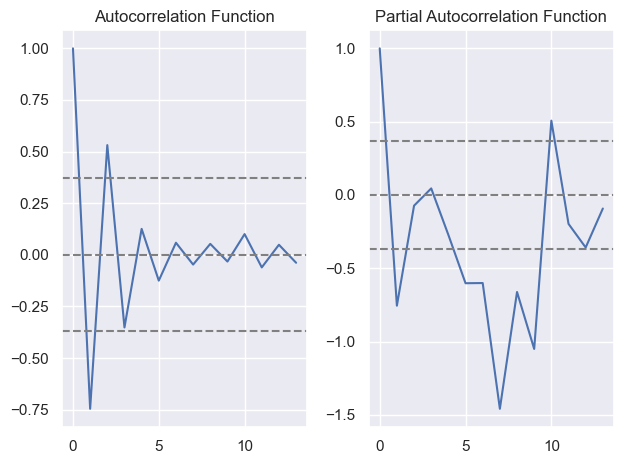

In [28]:
p,q=findParameters(stationarized_series)

## ARIMA Model Parameter Identification

Based on the ACF and PACF plots:

- The PACF plot displays a sharp cut-off after the first lag, suggesting an AR(1) component could be appropriate for the ARIMA model that is Parameter **"p"** can be 1.
- Conversely, the ACF plot shows a more gradual decline, so lets try different values and find the best parameters according to the AIC and BIC Test.

Therefore, the initial parameters for an ARIMA model could start with `p=1` for the AR part and could consider various values for `q` based on the ACF plot.

In [29]:
from statsmodels.tsa.arima.model import ARIMA
def fitAR(ts_log_moving_avg_diff_diff, p, q):
    f = plt.figure(figsize=(12,7))
    # AR Model
    model = ARIMA(ts_log_moving_avg_diff_diff, order=(p, q, 0))
    results_AR = model.fit()
    plt.plot(ts_log_moving_avg_diff_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_moving_avg_diff_diff)**2))
    return results_AR, results_AR.fittedvalues


### Lets try with p = 1; q=1

                               SARIMAX Results                                
Dep. Variable:            Total (TWh)   No. Observations:                   28
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  27.058
Date:                Wed, 24 Apr 2024   AIC                            -50.116
Time:                        00:11:31   BIC                            -47.525
Sample:                    01-01-1990   HQIC                           -49.346
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8419      0.087     -9.637      0.000      -1.013      -0.671
sigma2         0.0075      0.001      5.709      0.000       0.005       0.010
Ljung-Box (L1) (Q):                   6.64   Jarque-

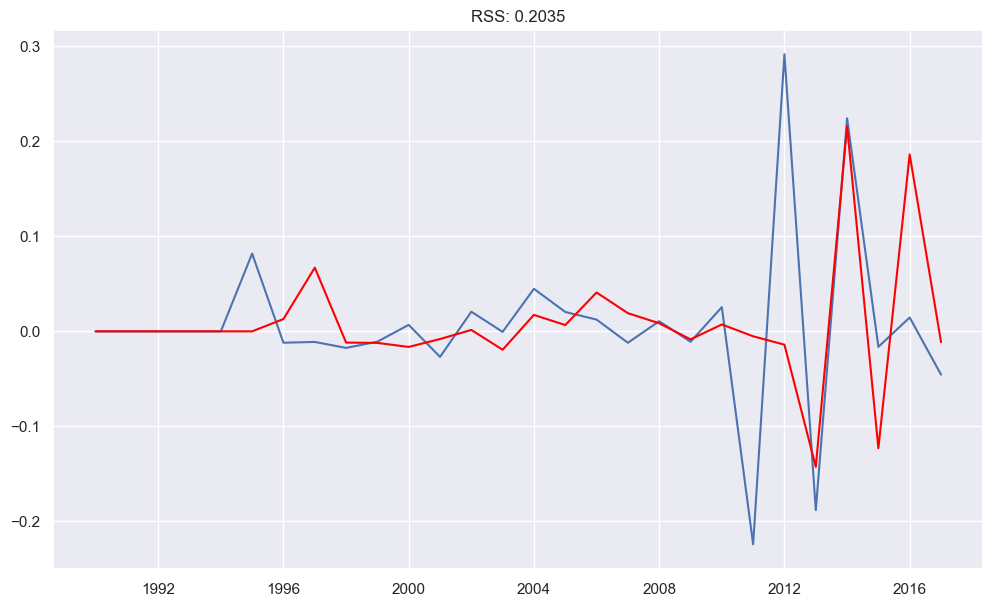

In [30]:
fitted_modelAR,fitted_valuesAR=fitAR(stationarized_series, 1, 1)
print(fitted_modelAR.summary())
print(fitted_valuesAR)

## Evaluation for parameters (1,1)

- **AIC (Akaike Information Criterion):** The model has an AIC of -50.116.
  
- **BIC (Bayesian Information Criterion):** The model has a BIC of -47.525.
  
- **HQIC (Hannan-Quinn Information Criterion):** The model has an HQIC of -49.346.


### Lets try with p = 1; q=0

                               SARIMAX Results                                
Dep. Variable:            Total (TWh)   No. Observations:                   28
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  38.423
Date:                Wed, 24 Apr 2024   AIC                            -70.846
Time:                        00:11:32   BIC                            -66.850
Sample:                    01-01-1990   HQIC                           -69.624
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.007      1.018      0.309      -0.007       0.021
ar.L1         -0.7303      0.085     -8.566      0.000      -0.897      -0.563
sigma2         0.0037      0.001      6.308      0.0

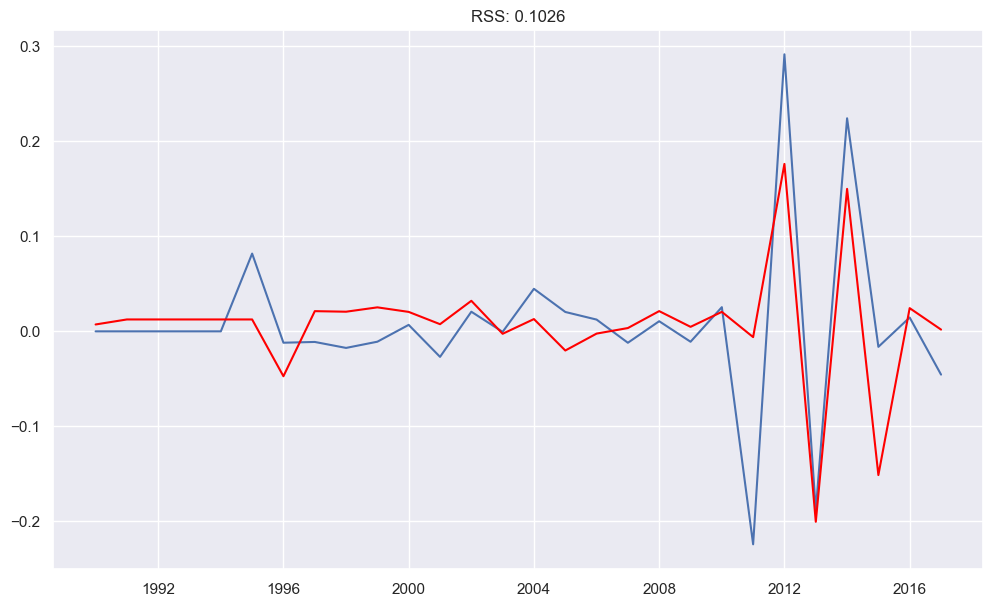

In [31]:
fitted_modelAR,fitted_valuesAR=fitAR(stationarized_series, 1, 0)
print(fitted_modelAR.summary())
print(fitted_valuesAR)

## Evaluation for parameters (1,0) : This is better 

- **AIC (Akaike Information Criterion):** The model has an AIC of -70.846.
  
- **BIC (Bayesian Information Criterion):** The model has a BIC of -66.850.
  
- **HQIC (Hannan-Quinn Information Criterion):** The model has an HQIC of -69.624.
    
Since these parameters lead to a much better(i.e More Negative) AIC, BIC AND HQIC, we will use these parameters for ARIMA model.


In [32]:
def calculate_error_metrics(actual_values, predicted_values):
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    print('Mean Absolute Error(MAE) : \t',mae)
    print('Mean Squared Error(MSE) : \t',mse)
    print('Root Mean Squared Error(RMSE) : ',rmse)

calculate_error_metrics(stationarized_series, fitted_valuesAR)




Mean Absolute Error(MAE) : 	 0.03842488970022474
Mean Squared Error(MSE) : 	 0.003663503099566916
Root Mean Squared Error(RMSE) :  0.06052687914940697


## Model Accuracy Evaluation

The error metrics for the fitted model are as follows:

- **Mean Absolute Error (MAE):** 0.0384
- **Mean Squared Error (MSE):** 0.0037
- **Root Mean Squared Error (RMSE):** 0.0605

These low error values imply that the fitted model is highly accurate and reliable for predicting future data. The small magnitude of the errors suggests that the model's predictions are very close to the actual values, indicating a strong performance.


In [33]:
stationarized_series = pd.DataFrame(stationarized_series)
stationarized_series.reset_index(inplace = True)
stationarized_series.rename(columns = {'Year':'ds', 'Total (TWh)':'y'},inplace=True)


### Getting Production Forecasts from ARIMA for next 30 Years

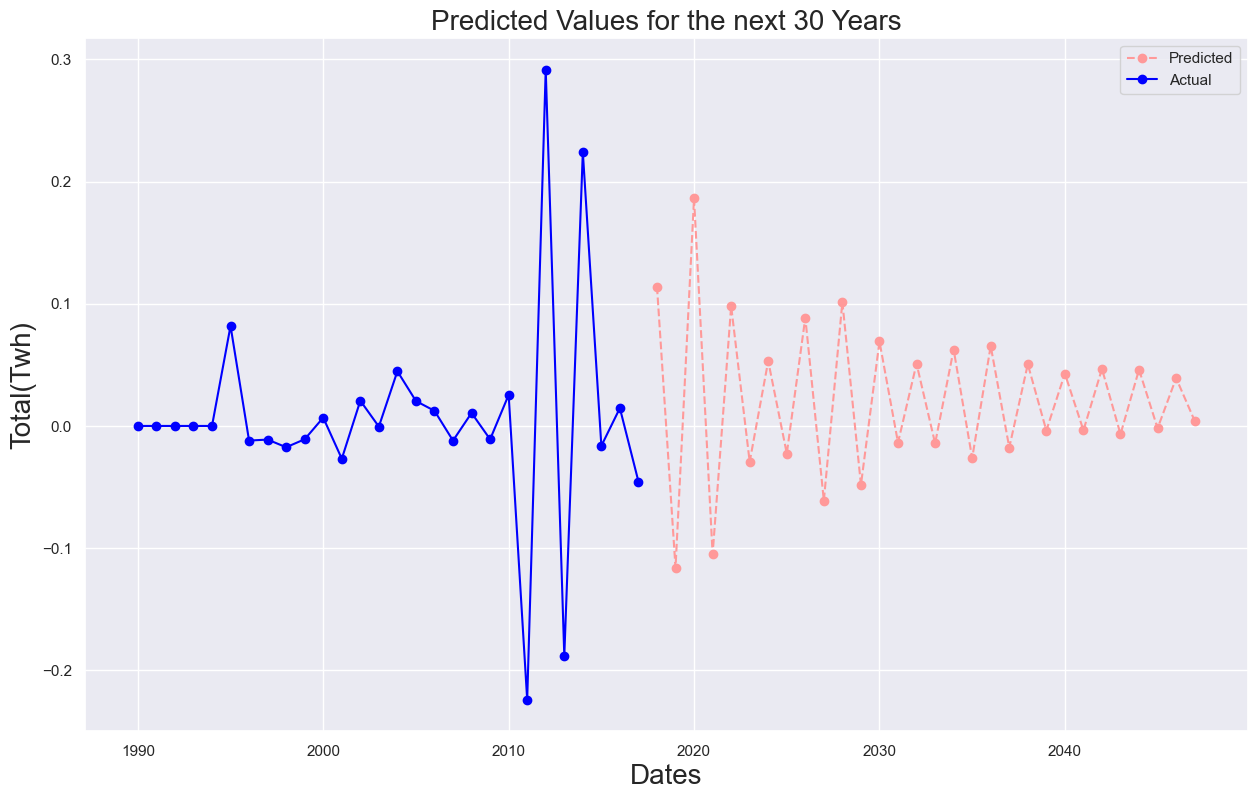

In [34]:
order=(5,1,0)
def ARIMApredictions(data, value, order=order):
    # Fit the ARIMA model
    arima = ARIMA(data['y'], order=order)
    arima_fit = arima.fit() 
    
    # Forecasting the next 30 years
    forecast = arima_fit.forecast(steps=30)
    
    start_date = data['ds'].iloc[-1]
    prediction_dates = [start_date + pd.DateOffset(years=i) for i in range(1, 31)]
    
    # Plotting actual vs predicted values
    plt.figure(figsize=(15, 9))
    plt.xlabel("Dates", fontsize=20)
    plt.ylabel(value, fontsize=20)
    plt.title("Predicted Values for the next 30 Years", fontsize=20)

    plt.plot_date(y=forecast, x=prediction_dates, linestyle='dashed', color='#ff9999', label='Predicted')
    plt.plot_date(y=data['y'], x=data['ds'], linestyle='-', color='blue', label='Actual')
    plt.legend()
    
    return forecast, prediction_dates


forecasts, prediction_dates = ARIMApredictions(stationarized_series, 'Total(Twh)', order=(5, 1, 0))
plt.show()

## De-stationarizing Forecasted Data

Having obtained forecasts from the stationarized data, our next step is to revert these forecasts back to their original scale to interpret the actual future values. This process, known as de-stationarizing, will align our forecasted values with the original data's scale, allowing us to understand these predictions in the context of the original time series data.


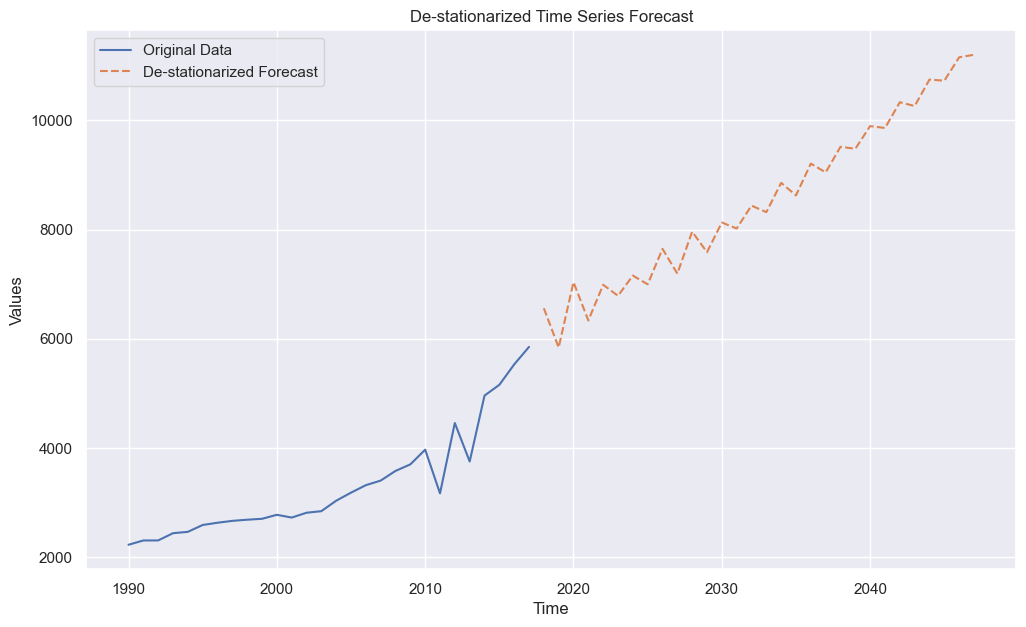

In [35]:
def de_stationarize(forecasted_values, last_log_moving_avg_diff, moving_avg, timeseries):
    """
    Revert the stationarizing transformations to get actual forecast values.
    """
    forecast_index = pd.date_range(start=timeseries.index[-1] + pd.offsets.YearBegin(1),
                                   periods=len(forecasted_values), freq='AS')
    
    # Reversing differencing
    reversed_diff = np.cumsum(forecasted_values) + last_log_moving_avg_diff
    
    reversed_log_transform = reversed_diff + moving_avg
    
    # Reversing the logarithmic transformation
    reversed_original_scale = np.exp(reversed_log_transform)
    
    # Constructing the zero_mask with the appropriate index
    zero_mask = (timeseries == 0)
    zero_mask = zero_mask.reindex(forecast_index, method='ffill')
    
    # Applying the mask
    reversed_original_scale[zero_mask] = 0
    return pd.Series(reversed_original_scale, index=forecast_index)

last_log_moving_avg_diff = log_diff_data.iloc[-1]
moving_avg_forecast_period = moving_avg_series[-1]
original_timeseries = target_data

de_stationarized_forecast = de_stationarize(
    forecasted_values=forecasts.values,
    last_log_moving_avg_diff=last_log_moving_avg_diff,
    moving_avg=moving_avg_forecast_period,
    timeseries=original_timeseries
)

# Plotting the de-stationarized forecast alongside the original time series for comparison
plt.figure(figsize=(12, 7))
plt.plot(original_timeseries.index, original_timeseries, label='Original Data')
plt.plot(de_stationarized_forecast.index, de_stationarized_forecast, label='De-stationarized Forecast', linestyle='--')
plt.title('De-stationarized Time Series Forecast')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


### The forecasted value of Total Renewable Energy Production in the year 2047 is 11200.70 terawatt-hours (TWh).


In [36]:
value_at_2047 = de_stationarized_forecast.loc[pd.Timestamp('2047-01-01')]
value_at_2047

11200.682790344692

## SARIMAX Model Cross-Validation

We perform time-series cross-validation on the SARIMAX model to assess its predictive accuracy. Cross-validation is essential in time-series analysis due to the sequential nature of the data, and it helps in understanding the model's performance over different time intervals.


In [37]:
# Suppress warnings for cleaner output
warnings.simplefilter('ignore')

# Ensuring the series is correctly formatted with datetime index and numeric values
stationarized_series.index = pd.to_datetime(stationarized_series.index)
stationarized_series['y'] = pd.to_numeric(stationarized_series['y'], errors='coerce')

stationarized_series.dropna(inplace=True)

# Defining a function to perform time-series cross-validation on SARIMAX model
def sarimax_cross_validation(timeseries, order, seasonal_order, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for train_index, test_index in tscv.split(timeseries):
        cv_train, cv_test = timeseries.iloc[train_index], timeseries.iloc[test_index]
        model = SARIMAX(cv_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)  # Set disp=False to avoid convergence messages
        predictions = model_fit.forecast(steps=len(cv_test))
        
        # Ensure predictions do not contain NaNs
        if np.isnan(predictions).any():
            continue  # Skip this split if predictions contain NaN
        
        mse = mean_squared_error(cv_test, predictions)
        cv_scores.append(mse)

    return cv_scores


order = (1, 1, 0)  
seasonal_order = (1, 1, 0, 12)  
n_splits = 5 

# Running the cross-validation
cv_scores = sarimax_cross_validation(stationarized_series['y'], order, seasonal_order, n_splits)

# Printing the cross-validation scores
print(cv_scores)


[0.003888302977088406, 0.03820256087934624, 0.06558919482615626]


### Interpretation of Cross-Validation Results

The cross-validation results yield low MSE values: `[0.004, 0.038 , 0.065]` which shows that the predictive model is robust and performs well on the validation data, which is encouraging for its potential application in real-world scenarios.


In [38]:
consumption_df = pd.read_csv('Continent_Consumption_TWH.csv')
consumption_df = consumption_df[['Year','World']]
consumption_df['Year'] = pd.to_datetime(consumption_df['Year'], format='%Y')
consumption_df.set_index('Year', inplace=True)

In [39]:
consumption_df.head()

,World
Year,
1990-01-01,101855.54
1991-01-01,102483.56
1992-01-01,102588.23
1993-01-01,103646.56
1994-01-01,104449.03


### Forecasting Global Energy Consumption by 2047

Now, let's determine the increase in global consumption by the year 2047 through a series of steps:

1. **Testing Stationarity**: We'll begin by checking the stationarity of the global energy consumption time series data. This involves examining statistical properties such as mean and variance over time to assess whether they exhibit any significant trends or seasonality.

2. **Stationarizing the Data**: If the data is found to be non-stationary, we'll apply transformation techniques like differencing or decomposition to make it stationary. This step helps in removing any underlying trends or seasonality present in the data.

3. **Forecasting**: Using the ARIMA model, we'll generate forecasts for the global energy consumption for the next 30 years, up to the year 2047. This involves fitting the ARIMA model to the stationary data and predicting future values based on historical patterns and trends.

4. **De-stationarizing**: Finally, we'll de-stationarize the forecasted values to obtain the estimated value of global energy consumption in the year 2047. This step reverses the transformations applied earlier, allowing us to interpret the forecasted values in their original scale.

By following these steps, we can gain insights into the projected increase in global energy consumption and better understand its implications for future energy planning and sustainability efforts.


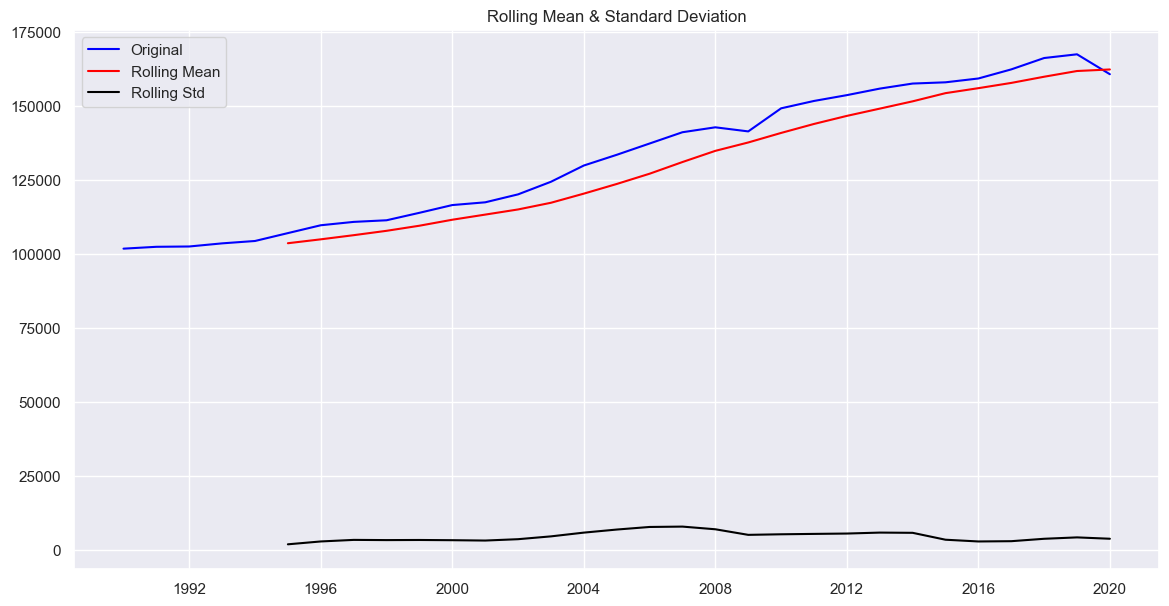

Results of Dickey-Fuller Test:
Test Statistic                 -0.585179
p-value                         0.874296
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64

Results of KPSS Test:
Test Statistic           0.861134
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [40]:
test_stationarity(consumption_df)

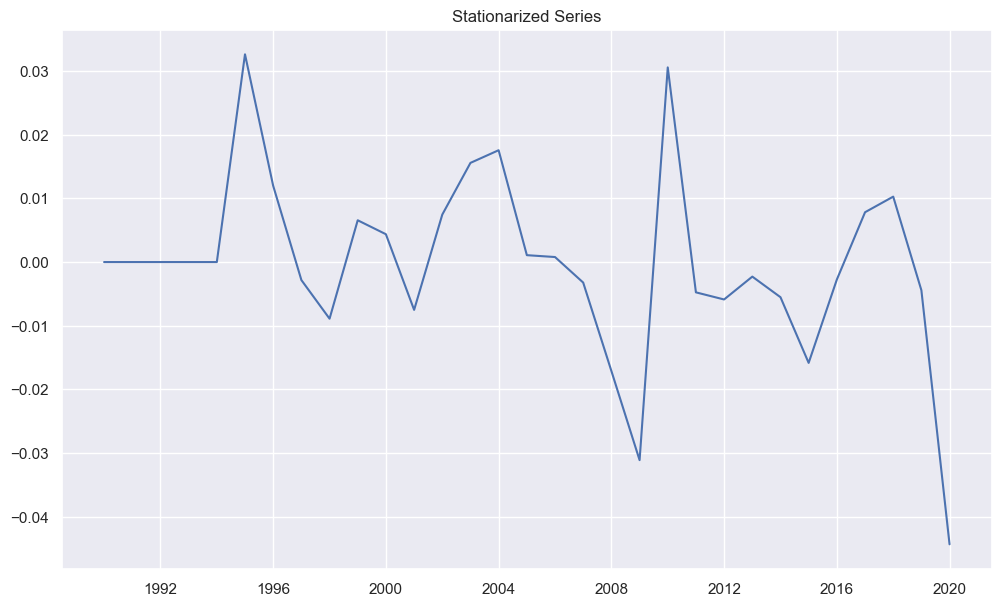

In [41]:
log_data_c, moving_avg_series_c, log_diff_data_c,stationarized_series_c = stationarizing(consumption_df)

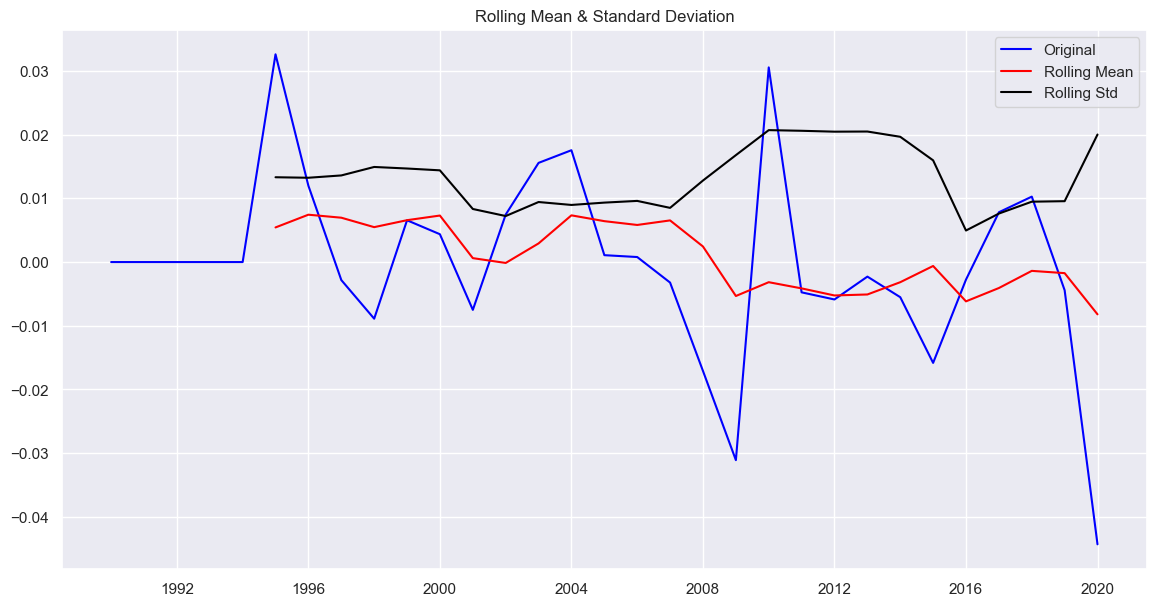

Results of Dickey-Fuller Test:
Test Statistic                 -3.922440
p-value                         0.001876
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64

Results of KPSS Test:
Test Statistic           0.360735
p-value                  0.094080
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [42]:
test_stationarity(stationarized_series_c)

## Stationarity Achieved

After applying the necessary transformations and tests, we have achieved stationarity in our time series data:

- The Test Statistic of the Dickey-Fuller test is **smaller than the critical values at all common significance levels** (1%, 5%, and 10%).
- This implies that we can **reject the null hypothesis with 99% confidence**, which posits that the series has a unit root and is non-stationary.
- We now have a **stationary series** that is suitable for modeling with ARIMA or other statistical methods that assume stationarity.

With stationarity established, we can proceed with fitting an ARIMA model to the data for forecasting or further analysis.


In [43]:
stationarized_series_c = pd.DataFrame(stationarized_series_c)
stationarized_series_c.reset_index(inplace = True)
stationarized_series_c.rename(columns = {'Year':'ds', 'World':'y'},inplace=True)
stationarized_series_c = stationarized_series_c[:-2]

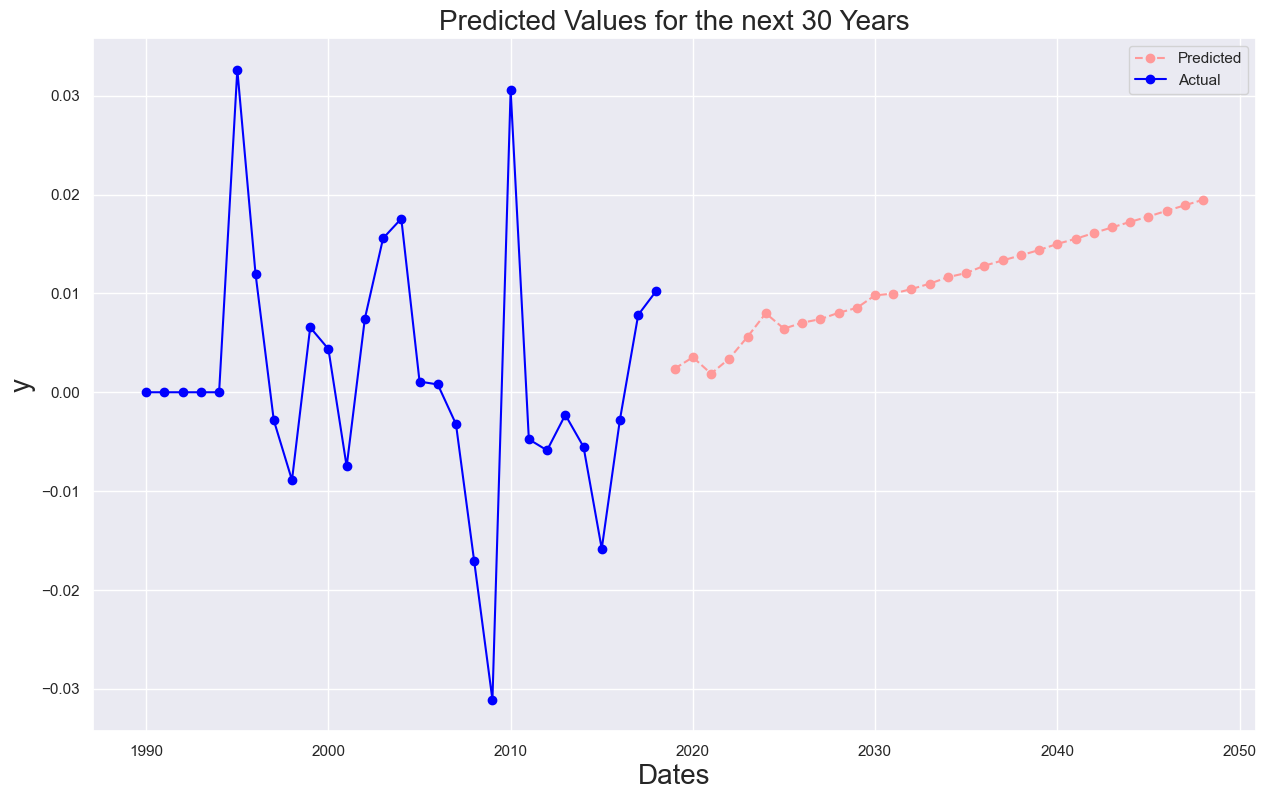

In [44]:
forecasts_c, prediction_dates_c = ARIMApredictions(stationarized_series_c, 'y', order=(5, 2, 1))
forecasts_c = np.array(forecasts_c)
plt.show()

### Lets destationarize the predictions to find out actual value

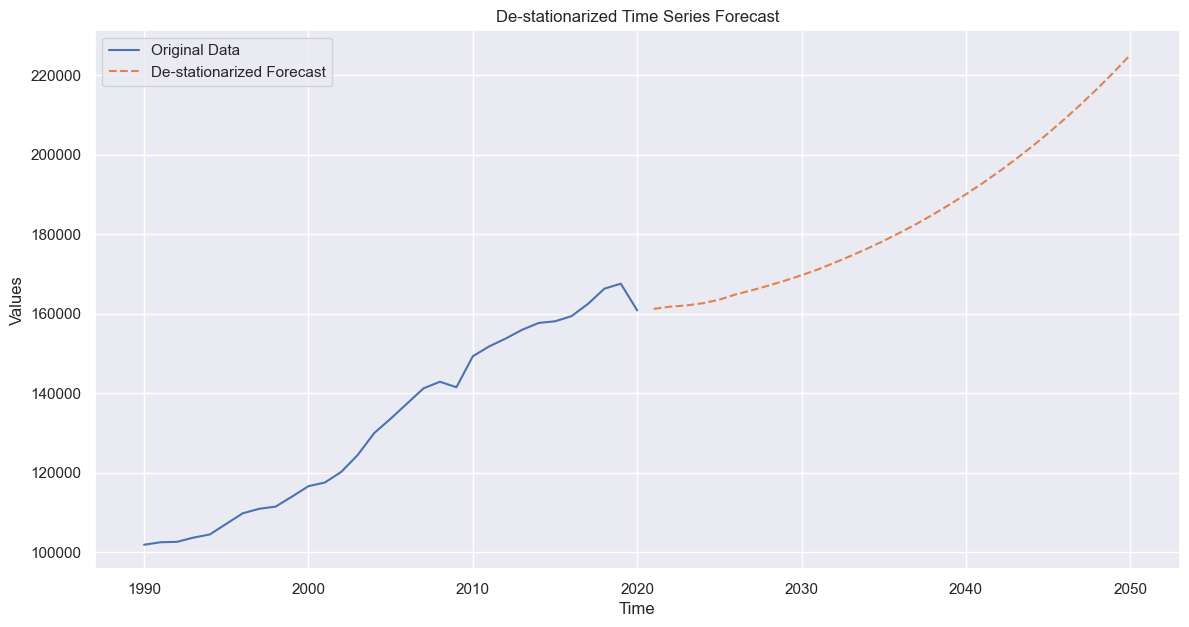

In [45]:
def de_stationarize(forecasted_values, last_log_moving_avg_diff, moving_avg, timeseries):
    
    reversed_diff = np.cumsum(forecasted_values) - 0.009752
    
    reversed_log_transform = reversed_diff + moving_avg if np.isscalar(moving_avg) else reversed_diff + np.full_like(reversed_diff, moving_avg)
    
    # Reversing the logarithmic transformation
    de_stationarized_forecast = np.exp(reversed_log_transform)
    
    forecast_period = pd.date_range(start=timeseries.index[-1] + pd.DateOffset(days=1),
                                    periods=len(forecasted_values), freq='AS')
    
    de_stationarized_forecast = pd.Series(de_stationarized_forecast, index=forecast_period)
    
    return de_stationarized_forecast

last_log_moving_avg_diff_c = log_diff_data_c.iloc[-1]
moving_avg_forecast_period_c = moving_avg_series_c.iloc[-1]
original_timeseries_c = consumption_df


de_stationarized_forecast_c = de_stationarize(
    forecasted_values=forecasts_c,  # Ensure this is a numpy array of forecasted values
    last_log_moving_avg_diff=last_log_moving_avg_diff_c,
    moving_avg=moving_avg_forecast_period_c,
    timeseries=original_timeseries_c
)

# Plotting the de-stationarized forecast alongside the original time series for comparison
plt.figure(figsize=(14, 7))
plt.plot(original_timeseries_c.index, original_timeseries_c, label='Original Data')
plt.plot(de_stationarized_forecast_c.index, de_stationarized_forecast_c, label='De-stationarized Forecast', linestyle='--')
plt.title('De-stationarized Time Series Forecast')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


### The forecasted value of Total Global Energy Consumption in the year 2047 is 212745.22 terawatt-hours (TWh).


In [46]:
de_stationarized_forecast_c['2047-01-01 ']

212745.21745635473

In [47]:
(11200.682790344692/212745.21745635473)*100

5.264834116725817

**Our analysis aimed to determine whether the production share of renewable energy would keep pace with the rising global consumption of energy by the year 2047. Using historical data as a base and incorporating trends in technology, policy, and economic factors, our forecast model projected that the share of renewable energy in 2047 will be approximately 5.27%, up from around 3.60% in 2017. This indicates that while renewable energy sources are contributing to the global energy mix, they still represent a relatively small portion of the overall energy consumption.**

